# Data Science Lydia | Danieau Pierre-Louis
# 1. Test Technique

**Rappel du sujet :**
En tant que Data Scientist missionné par l’entreprise Aidyl (fictive), nous avons accès à
un fichier `train.csv` contenant des données d’employés de longue date, qui ont passé une
évaluation RH de satisfaction. Un autre fichier `test.csv` nous est également remis. Celui-ci
contient les données des salariés les plus récents, qui n’ont pas encore passé d’évaluation
de satisfaction. Notre objectif est de développer un modèle permettant d’inférer la
satisfaction de ces derniers.

### Table of Contents

* [I/ 1) Statistiques descriptives]
    * [Part 1 : Question 1]
    * [Part 1 : Question 2]
    * [Part 1 : Question 3]

* [I/ 2) Apprentissage]
    * [Part 2 : Question 1]
    * [Part 2 : Question 2]
    * [Part 2 : Question 3]
    * [Part 2 : Question 4]

## I/ 1) : Statistiques descriptives

### Quelques analyses préliminaires

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
import plotly.express as px
from collections import Counter

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm


# Importation Data
data = pd.read_csv('/content/drive/MyDrive/Perso/datascience_lydia/train.csv')  # change path of the train set
test = pd.read_csv('/content/drive/MyDrive/Perso/datascience_lydia/test.csv')   # change path of the test set

In [2]:
print("Taille dataset d'entraînement : " , data.shape)
print('')
data.head()

Taille dataset d'entraînement :  (984, 24)



,EmployeeNumber,Satisfaction,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StandardHours,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,261,0,35,Travel_Rarely,Research & Development,23,2,Life Sciences,Male,2,2,Manufacturing Director,5916,3,Yes,3,40.0,0,1,3,1,0,0,1
1,981,1,53,Travel_Rarely,Sales,2,2,Medical,Male,3,4,Manager,14852,6,No,3,40.0,1,3,4,17,13,15,2
2,1157,0,33,Travel_Rarely,Sales,9,4,Marketing,Female,3,2,Sales Executive,8224,0,Yes,3,40.0,0,3,3,5,2,0,3
3,1666,1,43,Travel_Rarely,Research & Development,15,2,Life Sciences,Male,2,4,Research Director,17603,1,No,4,40.0,1,3,3,14,10,6,11
4,721,1,39,Travel_Rarely,Research & Development,2,4,Technical Degree,Female,2,2,Healthcare Representative,4553,1,No,3,40.0,0,4,3,20,7,11,10


In [3]:
print("Taille dataset de test : " , test.shape)
print('')
test.head()

Taille dataset de test :  (486, 23)



,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StandardHours,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,391,37,Travel_Rarely,Research & Development,1,3,Life Sciences,Female,3,1,Research Scientist,2115,1,No,3,40.0,0,3,3,17,12,5,7
1,1076,43,Travel_Rarely,Sales,25,3,Medical,Male,2,3,Sales Executive,10798,5,No,3,40.0,1,5,3,1,0,0,0
2,479,36,Non-Travel,Sales,1,5,Medical,Female,3,2,Sales Executive,6653,4,No,3,40.0,0,6,3,1,0,0,0
3,1641,40,Travel_Rarely,Research & Development,16,3,Life Sciences,Female,3,3,Manufacturing Director,7945,6,Yes,3,40.0,0,2,2,4,2,3,3
4,689,37,Travel_Rarely,Research & Development,3,3,Other,Male,3,3,Manufacturing Director,9434,1,No,3,40.0,1,2,3,10,7,7,8


In [4]:
print('Types de données: ', data.dtypes)
print('')
print('Check des valeurs manquantes : ', data.isnull().any())

Types de données:  EmployeeNumber               int64
Satisfaction                 int64
Age                          int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
Gender                      object
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
MonthlyIncome                int64
NumCompaniesWorked           int64
OverTime                    object
PerformanceRating            int64
StandardHours              float64
StockOptionLevel             int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole           int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
dtype: object

Check des valeurs manquantes :  EmployeeNumber             False
Satisfaction               False
Age                        F

Observations pour le dataset d'entraînement :
- 18 variables numériques :    
- 6 variables catégorielles :
    - 2 nominales : `BusinessTravel`, `OverTime`. 
    - 4 ordinales : `Department`, `EducationField`, `Gender`, `JobRole`.
- Aucune valeurs manquantes


In [5]:
print('Quelques descriptions des variables numériques :')
data.describe()

Quelques descriptions des variables numériques :


,EmployeeNumber,Satisfaction,Age,DistanceFromHome,Education,JobInvolvement,JobLevel,MonthlyIncome,NumCompaniesWorked,PerformanceRating,StandardHours,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.0,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,1017.984756,0.837398,36.905488,9.079268,2.922764,2.756098,2.040650,6406.361789,2.656504,3.155488,40.0,0.771341,2.794715,2.765244,7.033537,4.258130,2.215447,4.138211
std,607.994605,0.369189,9.177919,8.001641,1.043378,0.683673,1.103206,4702.460354,2.501657,0.362553,0.0,0.851993,1.294221,0.706582,6.119021,3.707301,3.198475,3.556434
min,1.000000,0.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1051.000000,0.000000,3.000000,40.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,480.250000,1.000000,30.000000,2.000000,2.000000,2.000000,1.000000,2849.250000,1.000000,3.000000,40.0,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,1016.500000,1.000000,36.000000,7.000000,3.000000,3.000000,2.000000,4775.500000,2.000000,3.000000,40.0,1.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,1552.250000,1.000000,43.000000,13.000000,4.000000,3.000000,3.000000,8244.750000,4.000000,3.000000,40.0,1.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,2068.000000,1.000000,60.000000,29.000000,5.000000,4.000000,5.000000,19999.000000,9.000000,4.000000,40.0,3.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


In [6]:
satisfaction_rate = data.Satisfaction.value_counts() / len(data)
satisfaction_rate

1    0.837398
0    0.162602
Name: Satisfaction, dtype: float64

Remarque :
- 84% des salariés semblent être satisfaits
- 16% des salariés semblent être insatisfaits

Point d'attention :     
La variable de prédicition `Satisfaction` est déséquilibrée, l'entraînement d'un modèle sur ce type de variable peut entraîner un biais. Plusieurs techniques pourront être utilisées avant d'entraîner le modèle comme le sous échantillonnage de la classe positive ou le sur échantillonnage de la classe négative ou encore la génération synthétiques d'exemples.


### **Part 1 : Question 1**

#### Etude de la redondance d'information entre les variables numériques avec la matrice de corrélation de pearson

Quelques hypothèses que j'émets sur les variables redondantes avant toutes analyses :    
- `JobLevel` & `MonthlyIncome` --> Plus un salarié a un poste important plus sont salaire est susceptible d'être élevé.
- `StockOptionLevel` & `JobLevel` --> Plus un salarié a de nombreuses parts dans la société plus son poste est susceptible d'être important.
- `Age` & `JobLevel` --> Le post devient généralement plus important avec l'âge.
- `YearsInCurrentRole` & `YearsWithCurrManager` --> Généralement plus on est a un poste depuis longtemps plus il est probable d'avoir le même manageur depuis longtemps.

Ce ne sont que des hypothèses. Vérifions les avec les calculs. 

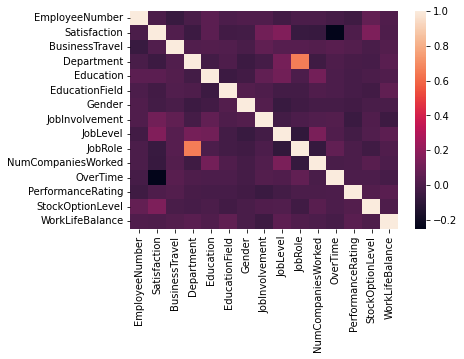

In [28]:
# Cration de la matrice de correlation 
corr_matrix = data.corr()
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)

In [29]:
#Variables avec la corrélation la plus importante (>0.5)
corr_matrix[corr_matrix>0.5]

,EmployeeNumber,Satisfaction,BusinessTravel,Department,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,WorkLifeBalance
EmployeeNumber,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Satisfaction,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.658631,NaN,NaN,NaN,NaN,NaN
Education,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationField,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JobInvolvement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JobLevel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
JobRole,NaN,NaN,NaN,0.658631,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN


Les variables numériques les plus rendondantes entre elles sont :     
- `JobLevel` avec chacune de ces variables indépendamment : (`Age`, `MonthlyIncome`, `YearsAtCompany`)
- `MonthlyIncome` avec la variable `YearsAtCompany`
- `YearsAtCompany` avec chacune de ces variables indépendamment : (`YearsInCurrentRole`, `YearsSinceLastPromotion`, `YearsWithCurrManager`) 
- `YearsInCurrentRole` avec chacune de ces variables indépendamment : (`YearsSinceLastPromotion`, `YearsWithCurrManager`)


Nos hypothèses initiales étaient bonnes à part celle sur la corrélation élevée entre `StockOptionLevel` & `JobLevel` qui ne s'avère pas exact. L'attribution de part de la société ne dépend pas autant de niveau de post auquel on pouvait penser. De quels critères dépend-t-il alors ? A vérifier sur de futures analyses.

#### Etude de la redondance d'information entre les variables catégorielles avec le test chi-square. 

Hypothèse initiale pour le test chi-square : 2 variables catégorielles n'ont aucune relations entre elles. 

Le test chi-square renvoit la probabilité de l'hypothèse ci-dessus.

In [9]:
# chi square test on all categorical variables
categorical_values=['Department', 'EducationField', 'Gender', 'JobRole','BusinessTravel', 'OverTime']
for i in range(len(categorical_values)-1):
  categorie_1 = categorical_values[i]
  for categorie_2 in categorical_values[i+1:]:
    CrosstabResult=pd.crosstab(index=data[categorie_1],columns=data[categorie_2])
    #chi-square test
    ChiSqResult = chi2_contingency(CrosstabResult)    
    print('La P-Value du test du chi square entre {} et {} est :'.format(categorie_1,categorie_2), ChiSqResult[1])

La P-Value du test du chi square entre Department et EducationField est : 7.804817121435283e-139
La P-Value du test du chi square entre Department et Gender est : 0.21858755617052308
La P-Value du test du chi square entre Department et JobRole est : 0.0
La P-Value du test du chi square entre Department et BusinessTravel est : 0.7748536965602999
La P-Value du test du chi square entre Department et OverTime est : 0.8891951048505884
La P-Value du test du chi square entre EducationField et Gender est : 0.8259895269886808
La P-Value du test du chi square entre EducationField et JobRole est : 1.7139429644364934e-93
La P-Value du test du chi square entre EducationField et BusinessTravel est : 0.4558278912908522
La P-Value du test du chi square entre EducationField et OverTime est : 0.506390915853974
La P-Value du test du chi square entre Gender et JobRole est : 0.15211908296815374
La P-Value du test du chi square entre Gender et BusinessTravel est : 0.06979310534851944
La P-Value du test du c

Resultat du test chi square : Si la probabilité P-Value est supérieure à 0.05 nous considérons que l'hypothèse de non dépendance entre deux variables catégorilles est vraie.

Les variables catégorielles corrélées 2 à 2 sont donc (P value <0.05) :    
- `Department` avec chacune de ces 2 variables : `EducationField`, `JobRole`
- `EducationField` avec la variable : `JobRole` 

Ces 3 variables sont donc corrélées 2 à 2. Ce qui paraît logique car l'éducation influe sur le parcours professionnel d'un salarié. 

#### Etude de la redondance d'information entre les variables numériques & catégorielles - Anaysis of Variance (ANOVA)

Dans un soucis d'efficacité nous émetterons uniquement des hypothèses dans cette partie que nous ne vérifierons pas. La méthode classique pour étudier la corrélation entre des variables catégorielles et des variables numériques est l'Analyse of Variance. 

Cependant voici quelques hypothèses de variables (numériques vs catégorielles) qui pourraient être corrélées entre elles :    
- `JobInvolvement` & `OverTime` : Plus un salarié est impliqué dans la société plus il est susceptible d'effectuer des heures supplémentaires.
- `BusinessTravel` & `WorkLifeBalance` : Plus un salarié a l'habitude de voyager régulièrement plus son équilibre de vie (pro vs famille) risque d'être déséquilibré.

Ceci ne sont que des hypothèses et méritent d'être vérifiées.

#### **Question I/1) conclusion** :     

De nombreuses variables nous ont semblé être redondantes. La plupart de nos hypothèses initiales ont été vérifié par le calcul. 

Pour rappel, voici les variables les plus redondantes 2 à 2 :     
- `JobLevel` avec chacune de ces variables indépendamment : (`Age`, `MonthlyIncome`, `YearsAtCompany`)
- `MonthlyIncome` avec la variable `YearsAtCompany`
- `YearsAtCompany` avec chacune de ces variables indépendamment : (`YearsInCurrentRole`, `YearsSinceLastPromotion`, `YearsWithCurrManager`) 
- `YearsInCurrentRole` avec chacune de ces variables indépendamment : (`YearsSinceLastPromotion`, `YearsWithCurrManager`)

- `Department` avec chacune de ces 2 variables : `EducationField`, `JobRole`
- `EducationField` avec la variable : `JobRole` 

- `JobInvolvement` & `OverTime` (non vérifié ANOVA)
- `BusinessTravel` & `WorkLifeBalance` (non vérifié ANOVA)


Les dangers d'une information redondante dans un dataset sont multiples :    
- Temps d'entraînement du modèle plus important
- Difficulté à comprendre les résultats
- Des modèles avec trop de caractéristiques en entrée (plus un modèle est simple plus il est interprétable)
- Overfitting
- Mauvaise compréhension du dataset

### Part 1 : Question 2

Plusieurs méthodes existent afin de sélectionner les caractéristiques d'un dataset qui influencent le plus la target. Nous allons comparer le résultat de 2 principales méthodes : 
- La corrélation entre les caractéristiques et la variable de `Satisfaction`
- La méthode *Mutual Information Selection*

Tout d'abord commençons par une analyse "*manuelle*" des caractéristiques des salariés considérés comme satisfaits.

#### Analyses préléminaires sur les facteurs influençant la satisfaction des salariés

In [10]:
data.StandardHours.value_counts()

40.0    984
Name: StandardHours, dtype: int64

Observation :     
- La variable `standardHours` ne comporte qu'une seule valeur (40.0) . Elle n'est donc d'aucune utilitée pour la prédiction car aucune "information" n'est comprise dedans. Nous pouvons alors la supprimer. 

In [11]:
# suppression de la variable 'StandardHours'
data.drop(columns=["StandardHours"],inplace=True) #train set
test.drop(columns=["StandardHours"],inplace=True) #test set
print("StandardHours" not in data.columns)
print("La variable a bien été supprimé du dataset")

True
La variable a bien été supprimé du dataset


Moyenne des caractéristiques des salariés suivant leur niveau de satisfaction

In [12]:
# Résumé (Satisfaction vs. Non-satisfaction)
satisfaction_Summary = data.groupby('Satisfaction')
satisfaction_Summary.mean()

,EmployeeNumber,Age,DistanceFromHome,Education,JobInvolvement,JobLevel,MonthlyIncome,NumCompaniesWorked,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Satisfaction,,,,,,,,,,,,,,,,
0,1023.94375,33.35625,9.875000,2.812500,2.581250,1.650000,4825.125000,3.031250,3.150000,0.487500,2.631250,2.75625,4.893750,2.806250,1.700000,2.781250
1,1016.82767,37.59466,8.924757,2.944175,2.790049,2.116505,6713.398058,2.583738,3.156553,0.826456,2.826456,2.76699,7.449029,4.540049,2.315534,4.401699


**Remarques :**  
D'après le tableau ci-dessus nous pouvons d'ores et déjà tirer quelques remarques concernant les caractéristiques des employés les plus satisfaits (Aucune relation de cause à effet n'est démontrée). 

Quelques caractéristiques moyennes d'un employé satisfait :     
- Plus âgés
- Distance de chez lui moins importante
- Salaire plus important
- Stock option plus important
- Plus d'années d'expérience dans l'entreprise, à son post et avec son manager actuel. (`YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`)

D'après cette courte analyse nous pouvons caractériser un employé satisfait comme un employé de longue date ayant une certaine stabilité. Il maîtrise son environnement de travail (Il occupe son poste depuis longtemps aux côtés de son manager), possède un salaire plus élevé et habite proche de chez lui. 

Les quelques caractéristiques qui retiennent mon attention :    
- En moyenne, un salarié satisfait et non satisfait sera tout aussi performant (`PerformanceRating` similaire) alors que nous aurions pu penser à une perte de motivation de la part des non satisfaits entraînant une performance moindre.
- L'équilibre entre la vie pro et la vie perso des salariés non satisfaits et satisfaits est similaire. Nous aurions pu penser à un équilibre disproportionné de la part des salariés non satisfaits.

Ces analyses nous permettent uniquement de dégager une tendance des caractéristiques des employés satisfaits.

#### Corrélation entre la variable de satisfaction et les autres variables

In [13]:
corr_matrix['Satisfaction'].sort_values(ascending  = False)

Satisfaction               1.000000
YearsInCurrentRole         0.172659
Age                        0.170494
YearsWithCurrManager       0.168217
JobLevel                   0.156116
YearsAtCompany             0.154172
MonthlyIncome              0.148248
StockOptionLevel           0.146878
JobInvolvement             0.112753
YearsSinceLastPromotion    0.071049
TrainingTimesLastYear      0.055685
Education                  0.046592
PerformanceRating          0.006673
WorkLifeBalance            0.005612
EmployeeNumber            -0.004321
DistanceFromHome          -0.043843
NumCompaniesWorked        -0.066043
StandardHours                   NaN
Name: Satisfaction, dtype: float64

Les variables : `YearsInCurrentRole`, `Age`, `YearsWithCurrManager`,`JobLevel`, `YearsAtCompany`, `MonthlyIncome`, `StockOptionLevel` sont les 7 variables qui sont le plus corrélées avec la variable de `Satisfaction`.

Nous retrouvons ainsi la plupart des features que nous avons trouvé lors de notre analyse "manuelle" ci dessus. A l'exception de la variable `DistanceFromHome` qui n'est pas corrélée à la satisfaction d'un salarié.

#### Information Mutuelle 

Les variables : `Age`, `DistanceFromHome`, `MonthlyIncome`, `YearsAtCompany`, `YearsInCurrentRole`, `YearsWithCurrManager`, `TrainingTimesLastYear` & `YearsSinceLastPromotion` sont des variables continues. Nous les transformons alors en variables discrètes afin de simplifier les futures analyses et la modélisation. Nous regroupons chacune de ces variables par ordre croissant avec des valeurs entières comprises entre 1 et 5 afin d'avoir un format similaire à `JobLevel` par exemple.

In [15]:
data_init = data.copy() # copy pour des analyses futures
test_init = test.copy()
result = pd.concat([data_init, test]) # concaténation pour regrouper toutes les variables en meme temps
result.head()

,EmployeeNumber,Satisfaction,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,261,0.0,35,Travel_Rarely,Research & Development,23,2,Life Sciences,Male,2,2,Manufacturing Director,5916,3,Yes,3,0,1,3,1,0,0,1
1,981,1.0,53,Travel_Rarely,Sales,2,2,Medical,Male,3,4,Manager,14852,6,No,3,1,3,4,17,13,15,2
2,1157,0.0,33,Travel_Rarely,Sales,9,4,Marketing,Female,3,2,Sales Executive,8224,0,Yes,3,0,3,3,5,2,0,3
3,1666,1.0,43,Travel_Rarely,Research & Development,15,2,Life Sciences,Male,2,4,Research Director,17603,1,No,4,1,3,3,14,10,6,11
4,721,1.0,39,Travel_Rarely,Research & Development,2,4,Technical Degree,Female,2,2,Healthcare Representative,4553,1,No,3,0,4,3,20,7,11,10


In [16]:
list_features_change=['Age', 'DistanceFromHome', 'MonthlyIncome', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager'] # liste des variables continues
for feature in list_features_change:
  result[feature]=pd.qcut(result[feature].values,5,[1,2,3,4,5],duplicates='drop')

result['TrainingTimesLastYear']=pd.qcut(result['TrainingTimesLastYear'],10,[1,2,3,4,5],duplicates='drop')
result['YearsSinceLastPromotion']=pd.qcut(result['YearsSinceLastPromotion'],10,[1,2,3,4,5],duplicates='drop')

result.head()

,EmployeeNumber,Satisfaction,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,261,0.0,3,Travel_Rarely,Research & Development,5,2,Life Sciences,Male,2,2,Manufacturing Director,4,3,Yes,3,0,1,3,1,1,1,1
1,981,1.0,5,Travel_Rarely,Sales,1,2,Medical,Male,3,4,Manager,5,6,No,3,1,2,4,5,5,5,2
2,1157,0.0,2,Travel_Rarely,Sales,3,4,Marketing,Female,3,2,Sales Executive,4,0,Yes,3,0,2,3,2,2,1,3
3,1666,1.0,4,Travel_Rarely,Research & Development,4,2,Life Sciences,Male,2,4,Research Director,5,1,No,4,1,2,3,5,5,4,5
4,721,1.0,4,Travel_Rarely,Research & Development,1,4,Technical Degree,Female,2,2,Healthcare Representative,3,1,No,3,0,3,3,5,4,5,5


In [17]:
# séparation du dataframe result pour retrouver les dataset train et test avec les variables regroupées en valeurs discrètes
data = result.iloc[:data.shape[0],:]
test = result.iloc[data.shape[0]:,:]
test.drop(columns=["Satisfaction"],inplace=True) # suppression de la colonne satisfaction ajoutée lors de la concaténation

print(data.shape)
print(test.shape)

(984, 23)
(486, 22)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
#label encoding des features catégorielles sur le train et le test

data[['BusinessTravel','Department','EducationField','Gender','JobRole','OverTime']]=data[['BusinessTravel','Department','EducationField','Gender','JobRole','OverTime']].apply(LabelEncoder().fit_transform)
test[['BusinessTravel','Department','EducationField','Gender','JobRole','OverTime']]=test[['BusinessTravel','Department','EducationField','Gender','JobRole','OverTime']].apply(LabelEncoder().fit_transform)
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,EmployeeNumber,Satisfaction,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,261,0.0,3,2,1,5,2,1,1,2,2,4,4,3,1,3,0,1,3,1,1,1,1
1,981,1.0,5,2,2,1,2,3,1,3,4,3,5,6,0,3,1,2,4,5,5,5,2
2,1157,0.0,2,2,2,3,4,2,0,3,2,7,4,0,1,3,0,2,3,2,2,1,3
3,1666,1.0,4,2,1,4,2,1,1,2,4,5,5,1,0,4,1,2,3,5,5,4,5
4,721,1.0,4,2,1,1,4,5,0,2,2,0,3,1,0,3,0,3,3,5,4,5,5


In [19]:
test.head()

,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,391,3,2,1,1,3,1,0,3,1,6,1,1,0,3,0,2,3,5,5,4,4
1,1076,4,2,2,5,3,3,1,2,3,7,5,5,0,3,1,4,3,1,1,1,1
2,479,3,0,2,1,5,3,0,3,2,7,4,4,0,3,0,5,3,1,1,1,1
3,1641,4,2,1,4,3,1,0,3,3,4,4,6,1,3,0,1,2,2,2,3,3
4,689,3,2,1,2,3,4,1,3,3,4,4,1,0,3,1,1,3,4,4,4,5


Correspondance des features avec les numéros sur le graph ci-dessous
                    feature num_graph
0                       Age         0
1            BusinessTravel         1
2                Department         2
3          DistanceFromHome         3
4                 Education         4
5            EducationField         5
6                    Gender         6
7            JobInvolvement         7
8                  JobLevel         8
9                   JobRole         9
10            MonthlyIncome        10
11       NumCompaniesWorked        11
12                 OverTime        12
13        PerformanceRating        13
14         StockOptionLevel        14
15    TrainingTimesLastYear        15
16          WorkLifeBalance        16
17           YearsAtCompany        17
18       YearsInCurrentRole        18
19  YearsSinceLastPromotion        19
20     YearsWithCurrManager        20


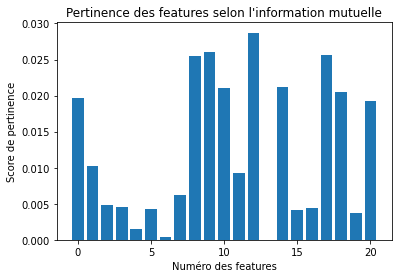

In [20]:
# Calcule du score de pertinence selon l'information mutuelle de sckitlearn

data_info_mutuelle=data[data.columns[2:]] #toutes les colonnes sauf la variable de Satisfaction et la variable EmployeeNumber
y_info_mutuelle = data['Satisfaction']
plt.bar(range(len(data_info_mutuelle.columns)), mutual_info_classif(data_info_mutuelle, y_info_mutuelle, discrete_features=True))
plt.xlabel('Numéro des features')
plt.ylabel('Score de pertinence')
plt.title("Pertinence des features selon l'information mutuelle")

graph_correspondance = pd.DataFrame(np.array([data_info_mutuelle.columns, range(len(data_info_mutuelle.columns))])).T
graph_correspondance.columns=['feature','num_graph']
print('Correspondance des features avec les numéros sur le graph ci-dessous')
print(graph_correspondance)

plt.show()

Plusieurs caratéristiques se démarquent : Celles dont la valeur sur le graphique ci-dessus est supérieure à `0.015`

In [21]:
bool_array = mutual_info_classif(data_info_mutuelle, y_info_mutuelle, discrete_features=True)>0.015 #filtre sur les caractéstiques >0.015
indices = np.where(bool_array)
print('Les caractéristiques les plus pertinentes sont (score > 0.015) : ', graph_correspondance[graph_correspondance.num_graph.isin(indices[0])].feature.values)

Les caractéristiques les plus pertinentes sont (score > 0.015) :  ['Age' 'JobLevel' 'JobRole' 'MonthlyIncome' 'OverTime' 'StockOptionLevel'
 'YearsAtCompany' 'YearsInCurrentRole' 'YearsWithCurrManager']


In [22]:
accessed_mapping = map(list(mutual_info_classif(data_info_mutuelle, y_info_mutuelle, discrete_features=True)).__getitem__, indices[0])
accessed_list = list(accessed_mapping)
info_mutuelle_resultat = pd.DataFrame(np.array([graph_correspondance[graph_correspondance.num_graph.isin(indices[0])].feature.values , accessed_list ])).T
info_mutuelle_resultat.columns=['feature','mutuelle_info_score']

print("Les caratéristiques avec le score de pertinence le plus élevé :")
print(" ")
print(info_mutuelle_resultat.sort_values(by = 'mutuelle_info_score',ascending  = False))

Les caratéristiques avec le score de pertinence le plus élevé :
 
                feature mutuelle_info_score
4              OverTime             0.02872
2               JobRole            0.026038
6        YearsAtCompany            0.025657
1              JobLevel            0.025432
5      StockOptionLevel            0.021231
3         MonthlyIncome             0.02103
7    YearsInCurrentRole            0.020492
0                   Age            0.019641
8  YearsWithCurrManager            0.019247


D'après l'information mutuelle, les caractéristiques qui influent le plus sur la variable `Satisfaction` sont :

 `OverTime`, `JobRole`,`YearsAtCompany`,`JobLevel`,`StockOptionLevel`, `YearsInCurrentRole` , `Age`,`YearsWithCurrManager`, `MOnthlyIncome`

#### Conclusion Q2

Les résultats de nos différentes analyses se regroupent. Toutes les varibales que nous avons déterminé comme fortement corrélées à la variation de la satisfaction d'un salarié se retrouvent dans l'étude sur l'information mutuelle. De plus les variables trouvées confirment la plupart de nos hypothèses. C'est pourquoi les variables qui influencent le plus la satisfaction d'un salarié sont (classés par ordre décroissant) :  
- `OverTime`, `JobRole`,`YearsAtCompany`,`JobLevel`,`StockOptionLevel`, `YearsInCurrentRole` , `Age`,`YearsWithCurrManager`, `MOnthlyIncome`

### Part 1 : Question 3

Un modèle entraîné sur un dataset d'entraînement ayant une distribution différente de celle du dataset de test sera moins performant. Les prédictions ne s'adapteront pas bien aux données du test set.

Il faut alors vérifier les distributions de chacune des variables des deux datasets. Une première méthode consiste à vérifier visuellement les distributions 2 à 2 et vérifier leurs similarités. Il est également possible de vérifier numériquement leurs distributions.


---



**Pour des variables numériques nous pouvons utiliser le Z-Test :**

Le Z-Test : Un test efficace pour comparer deux distributuons entre elles et vérifier numériquement leurs similarités ou non. 

Formule du Z Test :

$\ Z = \frac{\overline{X_1} - \overline{X_2}}{\sqrt{\sigma _{X1}^{2} + \sigma _{X2}^{2} }}$

Avec :     
- X1 : La moyenne de la première distribution
- X2 : La moyenne de la deuxième distribution
- $\sigma _{X1}^{2}$ : L'éccart type de la première distribution divisée par le nombre d'échantillons
- $\sigma _{X2}^{2}$ : L'éccart type de la deuxième distribution divisée par le nombre d'échantillons

De manière générale, si le Z test est inférieur à 2 nous pouvons considérer que les 2 distributions sont similaires. Si il est supérieur à 2, elles sont différentes. 

**Pour des variables catégorielles :**    
Nous pouvons vérifier la proportion de chacune des classes du train et test set et les comparer.


---


**Analyses visuelles :**

Vérifions visuellement que les distributions des variables sont identiques entre le train et le test set. Pour cela nous affichons sur le même graphique l'histogramme de chacune des features de manière proportionnelle (afin de pouvoir comparer les proportions des valeurs de chacune des features)

In [27]:
for feature in test.columns: # pour chacune des features du test set
  x0 = data_init[feature].values
  x1 = test_init[feature].values
  # concatenation dans un dataframe des valeurs du train et test set
  df =pd.DataFrame(dict(
      series=np.concatenate((["train set"]*len(x0), ["test set"]*len(x1))), 
      data  =np.concatenate((x0,x1))
  ))
  px.histogram(df, x="data", color="series", barmode="overlay", histnorm='percent',width=800, height=400,title="{}".format(feature)).show() #histogramme
  print('-----------------------')

-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


-----------------------


#### Conclusion Q3

Les distributions des variables communes aux deux fichiers sont visuellement similaires. Bien qu'il y ait quelques distinctions, cela ne viendra pas impacter de manière significative l'inférence de notre modèle sur les variables de tests.

## I/ 2) Apprentissage

### Part 2 : Question 1

Etant donnée que le dataset d'entraînement est déséquilibré à l'avantage des salariés satisfaits (target variable = 1) et que nous faisons face à un problème de classifcation binaire ( 0 ou 1 ), la métrique la plus appropriée semble être le **F1-Score**. Le F1-score permet de prendre en considération la précision et le rappel de notre modèle. 

$F1 = 2 * \frac{Precision * Recall}{Precision + Recall}$

avec :    
$Precision = \frac{True Positive}{TruePositive + FalsePositive}$

$Recall = \frac{TruePositive}{TruePositive + FalseNegative} $

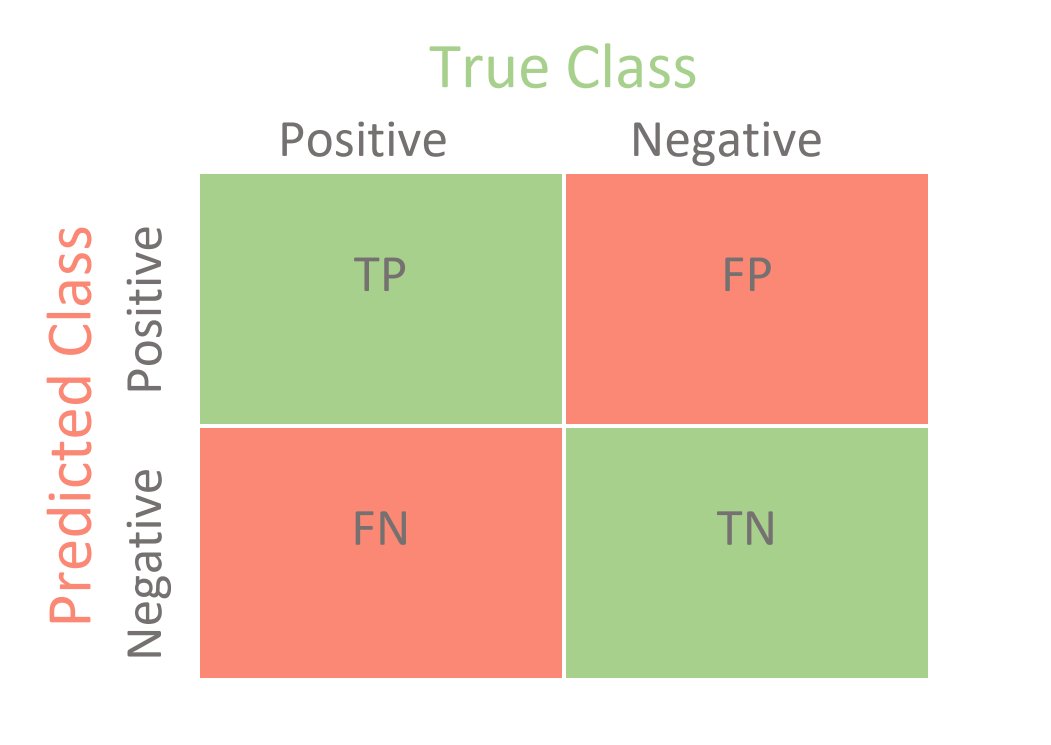

*Source photo : Joydwip Mohajon on towardsdatascience*


Concrètement, la précision nous indique la proportion de bonnes prédictions sur l'ensembles des prédictions réalisées. 
Parmi la précision il y a la précision de la classe positive, de la classe négative et la pondération des deux. 
La précision de classe positive nous indiquera la proportion de salariés satisfaits parmi les salariés prédits comme satisfaits.
De même pour la précision de la classe négative avec les salariés non satisfaits.

Le rappel, quant à lui, nous indique la proportion de bonnes prédictions sur l'ensemble des valeurs réelles.
Le rappel de la classe positive nous indiquera la proportion des salariés détectés comme satisfaits parmi ceux réellement satisfaits.
De même pour la classe négative avec les salariés non satisfaits. 

Cependant intéressons nous au problème spécifique étudié :

Nous souhaitons déterminer si un employé est satisfait ou non. Ce problème soulève plusieurs questions : Pourquoi cette entreprise souhaite-t-elle déterminer la satisfaction de ses employés ? Quelles actions veut-elle mettre en place ? Est-il plus important de détecter un salarié satisfait ou non satisfait ?

Nous pouvons d'ores et déjà imaginer quelques unes des réponses. Une entreprise souhaite avant tout pouvoir détecter les salariés non satisfaits afin de mettre en place un plan d'action adapté afin de satisfaire au mieux leurs attentes (entretien individuel, changement de poste, autres problèmes... ? ). Nous estimons donc qu'il est plus intéressant de détecter un salarié non satisfait (Quitte à ce que nous nous soyons trompé et qu'il soit effctivement satisfait. Nous nous en rendrons alors compte lors d'un entretien individuel par exemple.)

Etant donné ces hypothèses il est préférable d'optimiser la précision et le rappel de la classe négative. En effet, ce sont avant tout les salariés non satisfaits qui nous intéressent afin de mettre en place un plan d'action adéquat pour les satisfaire. Cependant ces 2 métriques ne prenant pas en compte la classe positive il faut tout de même s'intéresser au F1-score pondéré afin d'avoir une vision globale de nos modèles.

**C'est pourquoi la metrique que nous prendrons en considération est le F1-score avec une attention particulière à la précision et au rappel de la classe négative.**

### Part 2 : Question 2

Le modèle de régression logistique est adapté à notre problème de classification binaire et va permettre de classifier les salariés en fonction de leurs niveaux de satisfaction (0 ou 1).

Commençons par sélectionner les features en entrée de notre modèle. Pour cela nous allons nous aider de nos analyses précédentes. 
Pour rappel, les features les plus pertinentes sont : 
`OverTime`, `JobRole`,`YearsAtCompany`,`JobLevel`,`StockOptionLevel`, `YearsInCurrentRole` , `Age`,`YearsWithCurrManager`, `MOnthlyIncome`

Cependant d'après nos analyses de corrélation, nous remarquons que :     

- `JobLevel` et `MonthlyIncome` sont fortement corrélées.
- `YearsInCurrentRole` et `YearsWithCurrManager` sont également fortement corrélées.

De plus le modèle de régression logistique performe moins bien lorsqu'il est entraîné sur des variables fortement corrélées. C'est pourquoi nous faisons le choix de conserver `JobLevel` et `YearsInCurrentRole` au détriment des deux autres car leur score de pertinence est plus élevé d'après l'information mutuelle de la première partie.

Nous conservons donc 7 variables pour notre modèle :    
`OverTime`,`YearsInCurrentRole`, `Age`,`JobLevel`, `YearsAtCompany`, `StockOptionLevel`, `JobRole`

In [30]:
features = ['OverTime','YearsInCurrentRole', 'Age','JobLevel', 'YearsAtCompany', 'StockOptionLevel', 'JobRole'] # features conservées
X = data[features] # dataframe d'entrainement avec les bonnes features
test = test[features] #dataframe de test
y = data.Satisfaction

print('X : ',X.shape)
print('Target : ', y.shape)
print(' ')
print('X dataframe :')
X.head()

X :  (984, 7)
Target :  (984,)
 
X dataframe :


,OverTime,YearsInCurrentRole,Age,JobLevel,YearsAtCompany,StockOptionLevel,JobRole
0,1,1,3,2,1,0,4
1,0,5,5,4,5,1,3
2,1,2,2,2,2,0,7
3,0,5,4,4,5,1,5
4,0,4,4,2,5,0,0


Afin que les features aient des échelles de grandeurs similaires, on remplace la variable `Overtime` par une variable booléenne qui vaut 5 ou 0. 

In [31]:
X['OverTime'] = X['OverTime'].apply(lambda x: 5 if x==1 else 0)
test['OverTime'] = test['OverTime'].apply(lambda x: 5 if x==1 else 0)
X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,OverTime,YearsInCurrentRole,Age,JobLevel,YearsAtCompany,StockOptionLevel,JobRole
0,5,1,3,2,1,0,4
1,0,5,5,4,5,1,3
2,5,2,2,2,2,0,7
3,0,5,4,4,5,1,5
4,0,4,4,2,5,0,0


In [32]:
# stratification afin d'avoir les memes proportions de classes positives et négatives dans le dataset train et de validation
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.25,random_state=0, stratify=y)
print(Counter(y_train))
print(Counter(y_val))

Counter({1.0: 618, 0.0: 120})
Counter({1.0: 206, 0.0: 40})


Prédiction de la satisfaction des salariés de `test.csv`

In [33]:
logreg = LogisticRegression() # regression logistique
logreg.fit(X_train,y_train) # entrainement
y_test = logreg.predict(test) # prediction sur le dataset de test
test_init['Satisfaction'] = y_test #intégration des résultats dans le dataset de test

print("Nombre de salariés prédits comme satisfaits (1) et non satisfaits (0) : ", Counter(y_test))
print(' ')
print('Dataframe de test avec la colonne de Satisfaction')
test_init.head()

Nombre de salariés prédits comme satisfaits (1) et non satisfaits (0) :  Counter({1.0: 466, 0.0: 20})
 
Dataframe de test avec la colonne de Satisfaction


,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Satisfaction
0,391,37,Travel_Rarely,Research & Development,1,3,Life Sciences,Female,3,1,Research Scientist,2115,1,No,3,0,3,3,17,12,5,7,1.0
1,1076,43,Travel_Rarely,Sales,25,3,Medical,Male,2,3,Sales Executive,10798,5,No,3,1,5,3,1,0,0,0,1.0
2,479,36,Non-Travel,Sales,1,5,Medical,Female,3,2,Sales Executive,6653,4,No,3,0,6,3,1,0,0,0,1.0
3,1641,40,Travel_Rarely,Research & Development,16,3,Life Sciences,Female,3,3,Manufacturing Director,7945,6,Yes,3,0,2,2,4,2,3,3,1.0
4,689,37,Travel_Rarely,Research & Development,3,3,Other,Male,3,3,Manufacturing Director,9434,1,No,3,1,2,3,10,7,7,8,1.0


### Part 2 : Question 3

Nous allons comparer les performances du modèle de régression logistique avec ces différents autres modèles couramment utilisés lors de problèmes de classification :
- **Modèles de base** : Modèles simplistes qui servent de référence (par exemple satisfaction à 1 (ou 0) pour tous les salariés).
- **Arbre de décision** : Modèle dont les performances sont reconnues pour des problèmes de classification mais où il faut faire attention à l'overfitting.
- **SVM**: Modèle reconnu pour des problèmes de classification notamment lors de problème à plusieurs dimensions (ici 5).

Chacun des hyperparamètres de ces modèles ne seront pas optimisés. Il seront étudiés uniquement en guise de comparaison avec le modèle de régression logitisque et ainsi avoir une idée du meilleur modèle à appliquer. Cependant des analyses plus poussées sur les hyperparamètres devraient être étudiées ainsi que d'autres modèles testés (Random forest, XG Boost etc...)

1. Modèle de base (Tous les salariés satisfaits)




In [34]:
# Base model fonction with 1
def base_model_1(X) :
    y = 1 + np.zeros(X.shape[0]) # 1 pour tous les salariés (i.e. tous les salariés satisfaits)
    return y

y_pred_base_model_1 = base_model_1(X_val)
print('Model de base')
print('----')
print(classification_report(y_val, y_pred_base_model_1))

Model de base
----
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        40
         1.0       0.84      1.00      0.91       206

    accuracy                           0.84       246
   macro avg       0.42      0.50      0.46       246
weighted avg       0.70      0.84      0.76       246



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Interprétation :** Comme attendu, en mettant tous les salariés comme satisfait, la préicison et le rappel pour la classe 1 sont très bons. Cependant le modèle n'est pas utile car ce qui nous intéresse avant tout est de pouvoir détecté les salariés non satisfaits. Cependant la préicision et le rappel pour la classe positive (0.84 et 1.00) sont de bonnes références pour les modèles futurs.

2. Modèle de base (Tous les salariés non satisfaits)

In [36]:
# Base model fonction with 0
def base_model_0(X) :
    y = np.zeros(X.shape[0]) # 0 pour tous les salariés (i.e. tous les salariés non satisfaits)
    return y

y_pred_base_model_0 = base_model_0(X_val)
print('Model de base')
print('----')
print(classification_report(y_val, y_pred_base_model_0))

Model de base
----
              precision    recall  f1-score   support

         0.0       0.16      1.00      0.28        40
         1.0       0.00      0.00      0.00       206

    accuracy                           0.16       246
   macro avg       0.08      0.50      0.14       246
weighted avg       0.03      0.16      0.05       246



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



**Interprétation :** Inversement, en mettant tous les salariés à 0, nous obtenons des scores nuls pour la classe positive et de meilleurs résultats pour la classe négative : 

- Parmi tous les salariés qui sont prédits comme non satisfaits, il y en a 16% qui sont en effet non satisfaits.
- Parmi tous les salariés qui sont non satisfaits, il y en a 100% qui sont détectés --> **normal car tous les salariés à 0.**

Ce modèle n'est pas non plus intéressant car bien que tous les salariés non satisfaits soient détectés, cela impliquerait de convoquer chacun des salariés individuellement afin de connaître les raisons de leurs non satisfaction et cela ferait perdre beaucoup de temps aux services des ressources humaines. Le travail de "pré selection" des salariés non satisfaits n'est donc pas fait. Cependant les valeurs de préicison et de rappel pour la classe négative sont de bonnes références pour les modèles futurs.

3. Arbre de décision (En essayant de limiter l'overfitting sans étude très poussée)

In [37]:
# Decision Tree Model
dtree = DecisionTreeClassifier(
    max_depth=3, # empecher l'overfitting (estimation)
    class_weight="balanced",#Traiter chaque classe avec une importance égale (car unbalanced dataset)
    )

dtree = dtree.fit(X_train,y_train)

print("dataset de validation:")
print(classification_report(y_val, dtree.predict(X_val)))
print('  ')
print("Data set d'entrainement:")
print(classification_report(y_train, dtree.predict(X_train))) # Overfitting car scores supérieurs au dataset de validation

dataset de validation:
              precision    recall  f1-score   support

         0.0       0.29      0.50      0.37        40
         1.0       0.89      0.77      0.82       206

    accuracy                           0.72       246
   macro avg       0.59      0.63      0.60       246
weighted avg       0.79      0.72      0.75       246

  
Data set d'entrainement:
              precision    recall  f1-score   support

         0.0       0.42      0.67      0.52       120
         1.0       0.93      0.82      0.87       618

    accuracy                           0.80       738
   macro avg       0.67      0.74      0.69       738
weighted avg       0.84      0.80      0.81       738



**Interprétation :** 
- F1-score pondéré (validation) : 75%
- Precision classe 0 (validation) : 29%
- Rappel classe 0 (validation) : 50%

La préicison la classe négative est supérieure au modèle de base à 0 (tous les salariés non satisfaits). Le rappel de la classe négative est également satisfaisant (Parmi les salariés non satisfaist, 50% sont détectés). Le F1-score pondéré l'est également.

Cependant, on observe un ovefitting notable de notre arbe de décision. Nous pourrions mener des analyses afin de mieux généraliser notre modèle, notamment en optimisant les hyper paramètres. Nous pourrions également tester un Random Forest permettant probablement de réduire cet overfitting. 

4. SVM (Support Vector Machine) pour de la classification

In [38]:
svc = svm.SVC() #initial parameters
svc.fit(X_train,y_train)
print(classification_report(y_val, svc.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.50      0.15      0.23        40
         1.0       0.85      0.97      0.91       206

    accuracy                           0.84       246
   macro avg       0.68      0.56      0.57       246
weighted avg       0.80      0.84      0.80       246



**Interprétation :** Le F1-score pondéré est satisfaisant (80%). Cependant le F1-score de la classe négative est assez faible (23%). Parmi tous les salariés non satisfaits, il y en a seulement 15% qui sont détectés, ce qui est beaucoup trop faible car c'est très exactement ce qui est intéressant dans notre cas.

5. Regression logistique (modèle initial)

In [39]:
y_pred_log_reg = logreg.predict(X_val)
print(classification_report(y_pred_log_reg, y_val))

              precision    recall  f1-score   support

         0.0       0.17      0.47      0.25        15
         1.0       0.96      0.86      0.91       231

    accuracy                           0.83       246
   macro avg       0.57      0.66      0.58       246
weighted avg       0.91      0.83      0.87       246



**Interprétation :** Le modèle de régression logistique initial est satisfaisant.

**Précision :**
- Parmi les salariés qui sont prédits comme non satisfaits, il y en a 17% qui sont en effet non satisfaits. Dans ce cas, si le service des ressources humaines contacte les salariés qui sont prédits comme non satisfaits, il y aura un taux d'erreur de 83% (ce qui reste très élevé).
- Parmi les salariés qui sont prédits comme satisfaits, il y en a 96% qui sont effectivement satisfaits. Ce résultat nous importe peu car peu de plan d'actions sont envisageables sur les salriés satisfaits à part rester tel quel.

**Rappel:**
- Parmi tout ceux qui sont non satisfaits, il y en a 47% qui sont détectés. Ce résultat est l'un des plus importants. Nous contacterons donc 47% des personnes non satisfaites dans l'entreprise afin d'établir un plan d'action avec eux. 
- Parmi tout ceux qui sont satisfaits, il y en a 86% qui sont détectés. Résultat peu important dans notre cas car les salariés satisfaits ne nécessitent pas d'études complémentaires. 

Le F1-score de la classe 0 du modèle de base à 0 est de 0.28 alors que celui de la régression logistique est de 0.25, ce qui est donc satisfaisant.

**En conclusion de la question 3**, nous pouvons dire que la régression logitisque semble être le modèle le plus satisfaisant dans notre cas (bien que nous n'ayons pas optimiser ceux que nous avons testé et qu'il en existent plusieurs autres, notamment le random forest et des algorithmes de boosting.). Ce modèle de regression logistique est celui qui permet aux équipes RH de contacter avec le plus de précision les salariés non satisfaits tout en optimisant leurs marges d'erreurs (le nombre de salariés satisfaits contactés) qui leur fait perdre du temps. Si, pour l'entreprise, la satisfaction des employés est plus importante que le temps passé à trouver des solutions pour des salariés qui sont finalement satisfaits, nous pourrons nous arranger pour augmenter le taux de rappel de la classe négatif (qui est actuellement à 47%) afin de détecter davantage de salariés non satisfaits au détriment de score de précision. Ce compromis est un compromis courant en Machine Learning (précision - rappel). 

**Enregistrement des meilleures predictions du modèle de régression logistique sur le dataset de test pour la satisfaction des employés :**

In [40]:
# enregistrement au format csv des 10% des résultats avec les probabilités les plus élevées de satisfaction
y_pred_best = logreg.predict_proba(test)
test_init['Satisfaction_score'] = y_pred_best[:,1]  # classe de satisfaction uniquement
best_results = test_init.sort_values(by=['Satisfaction_score'], ascending=False)
best_results = best_results.iloc[:int(np.round(best_results.shape[0]*0.1)),:] # Les 10% des résultats avec les probabilités les plus élevées
best_results.to_csv('best_results.csv', index=False) # enregistrement
best_results.head() 

,EmployeeNumber,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,OverTime,PerformanceRating,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Satisfaction,Satisfaction_score
422,1656,50,Travel_Rarely,Research & Development,17,5,Life Sciences,Female,2,3,Research Director,13269,5,No,3,3,3,3,14,11,1,11,1.0,0.990947
148,532,56,Travel_Frequently,Sales,6,3,Life Sciences,Female,4,4,Sales Executive,13212,9,No,3,3,0,2,7,7,7,7,1.0,0.990378
384,1035,41,Non-Travel,Research & Development,7,1,Life Sciences,Female,1,5,Research Director,19973,1,No,4,2,3,3,21,16,5,10,1.0,0.987669
372,1288,44,Travel_Rarely,Research & Development,4,2,Life Sciences,Male,4,5,Manager,19190,1,No,3,2,4,2,25,9,14,13,1.0,0.987234
297,296,51,Travel_Rarely,Research & Development,8,4,Life Sciences,Male,2,3,Research Director,12490,5,No,3,2,5,1,10,9,4,7,1.0,0.986131


### Part 2 : Question bonus 
Si le dataset initial compte 10 000 fois plus de lignes ce qui rendrait le rendu de mon analyse impossible pour le lendemain en raison de l'entraînement trop long de la regression logistique, voici quelques options que je pourrai essayer :    
- Si j'en ai la possibilité, mettre en place un cluster Hadoop connecté à Pyspark pour accélérer de manière significative le temps de calcul mais la mise en place d'une telle architecture prend du temps.
- Réduire le nombre de caractéristiques en entrée du modèle. Je pourrai uniquement conserver les 2 plus importantes ou mettre en place un PCA mais rien ne me dit que le résultat sera prêt pour demain.  
- Sous échantilloner de manière aléatoire le dataset d'entraînement pour entraîner le modèle sur un dataset plus petit et inférer les résultats à l'ensemble du dataset. Nous pourrions réaliser plusieurs sous échantillons et comparer les résultats.




<img src="attachment:image.png" width="400">